In [1]:
import pandas as pd
import os
import json
from rdkit import Chem
from tqdm import tqdm
from collections import defaultdict
from pandarallel import pandarallel
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')



In [2]:
mcsa_row_path = '../dataset/raw_dataset/mcsa/'

In [3]:

def get_cluster(cluster_results_path):
    results = defaultdict(list)
    with open(cluster_results_path, 'r', encoding='utf-8') as f:
        data = [x.strip() for x in f.readlines()]
    for line in data:
        if '>Cluster' in line:
            cluster = line.replace('>', '')
            continue
        alphadb_id = line.split('>')[-1].split('.')[0]
        results[cluster].append(alphadb_id)
    return results

def convert_col(data):
    if len(data) == 1:
        return data[0]
    elif len(data) == 0:
        return {}
    else:
        print(data)
        raise ValueError()

def canonicalize_smiles(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        return Chem.MolToSmiles(mol)
    else:
        return ''
    
def wildcard_replace_by_methyl(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        methyl = Chem.MolFromSmiles('C')
        modified_mol = Chem.ReplaceSubstructs(mol, Chem.MolFromSmiles('*'), methyl)
        modified_smiles = Chem.MolToSmiles(modified_mol[0])
        return modified_smiles
    else:
        print('Warning replace wildcard erro')
        return smiles
    
def get_sub_dataset(max_sample, ec_site_dataset_path='../dataset/ec_site_dataset/',  
                merge_dataset_name_str='uniprot_ecreact_cluster_split_merge_dataset_limit_', 
                dataset_flag='train'):
    
    uniprot_ecreact_merge_dataset_path = os.path.join(ec_site_dataset_path, f'{merge_dataset_name_str}{max_sample}')
    dataset = pd.DataFrame()


    folder_path = os.path.join(uniprot_ecreact_merge_dataset_path, f'{dataset_flag}_dataset')
    csv_fnames = os.listdir(folder_path)
    pbar = tqdm(
        csv_fnames,
        total=len(csv_fnames),
        desc=f'{dataset_flag}'
    )


    for fname in pbar:
        df = pd.read_csv(os.path.join(folder_path, fname))
        # df = df[['alphafolddb-id', 'aa_sequence']]
        dataset = pd.concat([dataset, df])
            
    dataset['alphafolddb-id'] = dataset['alphafolddb-id'].apply(lambda x:x.split(';')[0])
    return dataset




In [4]:
chebi_df = pd.read_csv('../dataset/raw_dataset/chebi/structures.csv.gz')


In [5]:
df = pd.read_json(os.path.join(mcsa_row_path, 'catalytic_residues.json'))
for col in ['residue_chains', 'residue_sequences']:
    df[col] = df[col].apply(lambda x:convert_col(x))


In [6]:
df


,mcsa_id,roles_summary,function_location_abv,main_annotation,ptm,roles,residue_chains,residue_sequences
0,1,"activator, electrostatic stabiliser, hydrogen ...",,Acts as the general acid/base for Cys70 activa...,,"[{'group_function': 'activator', 'function_typ...","{'chain_name': 'A', 'pdb_id': '1b73', 'assembl...","{'uniprot_id': 'P56868', 'code': 'Asp', 'is_re..."
1,1,"activator, electrostatic stabiliser, hydrogen ...",,The catalytic general acid/base that deprotona...,,"[{'group_function': 'activator', 'function_typ...","{'chain_name': 'A', 'pdb_id': '1b73', 'assembl...","{'uniprot_id': 'P56868', 'code': 'Cys', 'is_re..."
2,1,"activator, hydrogen bond acceptor, proton acce...",,The catalytic general acid/base that re-proton...,,"[{'group_function': 'activator', 'function_typ...","{'chain_name': 'A', 'pdb_id': '1b73', 'assembl...","{'uniprot_id': 'P56868', 'code': 'Cys', 'is_re..."
3,1,"electrostatic stabiliser, hydrogen bond donor",,Activates Glu147,,"[{'group_function': '', 'function_type': 'inte...","{'chain_name': 'A', 'pdb_id': '1b73', 'assembl...","{'uniprot_id': 'P56868', 'code': 'His', 'is_re..."
4,1,"electrostatic stabiliser, hydrogen bond donor,...",,Activates Asp7,,"[{'group_function': '', 'function_type': 'inte...","{'chain_name': 'A', 'pdb_id': '1b73', 'assembl...","{'uniprot_id': 'P56868', 'code': 'Ser', 'is_re..."
...,...,...,...,...,...,...,...,...
5244,1004,"hydrogen bond donor, transition state stabiliser",main-N,Forms H-bond with the phosphate group of IP an...,,[{'group_function': 'electrostatic interaction...,"{'chain_name': 'A', 'pdb_id': '3lkk', 'assembl...","{'uniprot_id': '', 'code': 'Gly', 'is_referenc..."
5245,1004,"hydrogen bond donor, transition state stabiliser",main-N,Gly8 and Lys14 stabilise the transition state.,,[{'group_function': 'electrostatic interaction...,"{'chain_name': 'A', 'pdb_id': '3lkk', 'assembl...","{'uniprot_id': '', 'code': 'Gly', 'is_referenc..."
5246,1004,"electrostatic stabiliser, transition state sta...",,Form a catalytic motif: lysine triangle.,,[{'group_function': 'electrostatic interaction...,"{'chain_name': 'A', 'pdb_id': '3lkk', 'assembl...","{'uniprot_id': '', 'code': 'Lys', 'is_referenc..."
5247,1005,proton acceptor,,Acts as a nucleophile and deprotonates AdoHcy ...,,[{'group_function': 'proton shuttle (general a...,"{'chain_name': 'A', 'pdb_id': '1hnn', 'assembl...","{'uniprot_id': '', 'code': 'Glu', 'is_referenc..."


In [7]:
import json
residue_sequences_data = pd.read_json(json.dumps(df['residue_sequences'].tolist()))
residue_sequences_data


,uniprot_id,code,is_reference,resid
0,P56868,Asp,True,7
1,P56868,Cys,True,70
2,P56868,Cys,True,178
3,P56868,His,True,180
4,P56868,Ser,True,8
...,...,...,...,...
5244,,Gly,True,45
5245,,Gly,True,8
5246,,Lys,True,5
5247,,Glu,True,219


In [8]:
len(set(residue_sequences_data['uniprot_id']))


989

In [9]:
residue_sequences_data['is_reference'].sum()


5249

In [10]:
def download_all_mcas_data(
    page_one_url='https://www.ebi.ac.uk/thornton-srv/m-csa/api/entries/?format=json&page=1', 
    file_download_path='../dataset/raw_dataset/mcsa/all_entries_download/',
    merge_file_path='../dataset/raw_dataset/mcsa/all_entries.csv'):
    import wget
    wget.download(page_one_url, os.path.join(file_download_path, 'page_1.json'))
    
    page_one_df = pd.read_json(os.path.join(file_download_path, 'page_1.json'))
    
    def _download(cum_df, pre_df, curr_page=1):
        print('#'*10+'{}'.format(curr_page)+'#'*10)
        try:
            next_page_url = pre_df['next'][0]
            wget.download(next_page_url, os.path.join(file_download_path, f'page_{curr_page+1}.json'))
            next_page_df = pd.read_json(os.path.join(file_download_path, f'page_{curr_page+1}.json'))
            
            cum_df = pd.concat([cum_df, next_page_df], axis=0).reset_index(drop=True)
            return _download(cum_df, next_page_df, curr_page=curr_page+1)
        except:
            return cum_df
    
    all_entries_df = _download(page_one_df, page_one_df, curr_page=1)
    
    all_entries_df.to_csv(merge_file_path)
    
    return all_entries_df
        
        
    


In [11]:
merge_file_path=os.path.join(mcsa_row_path, 'all_entries.csv')
if os.path.exists(merge_file_path):
    all_entries_df = pd.read_csv(merge_file_path)
else:
    all_entries_df = download_all_mcas_data(merge_file_path=merge_file_path)


In [12]:
all_entries_df


,Unnamed: 0,count,next,previous,results
0,0,1003,https://www.ebi.ac.uk/thornton-srv/m-csa/api/e...,NaN,"{'mcsa_id': 1, 'enzyme_name': 'glutamate racem..."
1,1,1003,https://www.ebi.ac.uk/thornton-srv/m-csa/api/e...,NaN,"{'mcsa_id': 2, 'enzyme_name': 'beta-lactamase ..."
2,2,1003,https://www.ebi.ac.uk/thornton-srv/m-csa/api/e...,NaN,"{'mcsa_id': 3, 'enzyme_name': 'NAD(P)H dehydro..."
3,3,1003,https://www.ebi.ac.uk/thornton-srv/m-csa/api/e...,NaN,"{'mcsa_id': 4, 'enzyme_name': 'nitrite reducta..."
4,4,1003,https://www.ebi.ac.uk/thornton-srv/m-csa/api/e...,NaN,"{'mcsa_id': 5, 'enzyme_name': 'carboxypeptidas..."
...,...,...,...,...,...
998,998,1003,https://www.ebi.ac.uk/thornton-srv/m-csa/api/e...,https://www.ebi.ac.uk/thornton-srv/m-csa/api/e...,"{'mcsa_id': 1001, 'enzyme_name': 'Prolidase (X..."
999,999,1003,https://www.ebi.ac.uk/thornton-srv/m-csa/api/e...,https://www.ebi.ac.uk/thornton-srv/m-csa/api/e...,"{'mcsa_id': 1002, 'enzyme_name': 'Glucansucras..."
1000,1000,1003,NaN,https://www.ebi.ac.uk/thornton-srv/m-csa/api/e...,"{'mcsa_id': 1003, 'enzyme_name': 'Aspartate Am..."
1001,1001,1003,NaN,https://www.ebi.ac.uk/thornton-srv/m-csa/api/e...,"{'mcsa_id': 1004, 'enzyme_name': 'isopentenyl ..."


In [13]:
def _merge_rxn_aa_sequence(rxn_smiles, aa_sequence):
    try:
        reactants, products = rxn_smiles.split('>>')
        precursor = '{}|{}'.format(reactants, aa_sequence)
        return f'{precursor}>>{products}'
    except:
        return ''
def convert_to_ec_site_data(df, chebi_df):
    import wget
    
    def _qurey_smiles_from_chebi(chebi_id):
        this_id_data = chebi_df.loc[chebi_df['COMPOUND_ID']==int(chebi_id)]
        this_id_data = this_id_data.loc[this_id_data['TYPE']=='SMILES']
        smiles = this_id_data['STRUCTURE'].tolist()[0]
        return smiles
    
    def _download_mol_to_smiles(mol_file_url):
        tmppath = '/tmp/{}'.format(os.path.split(mol_file_url)[-1])
        mol_file_url = 'http://{}'.format(mol_file_url)
        wget.download(mol_file_url, tmppath)
        mol = Chem.MolFromMolFile(tmppath)
        if mol is not None:
            return Chem.MolToSmiles(mol)
        else:
            return ''
        
    
    def _get_aa_sequence(protein_data):
        uniprot_id = None
        try:
            uniprot_id = protein_data['sequences'][0]['uniprot_id']
            url = f'https://rest.uniprot.org/uniprotkb/{uniprot_id}.fasta'
            wget.download(url, f'/tmp/{uniprot_id}.fasta')
            
            aa_sequence = ''
            with open(f'/tmp/{uniprot_id}.fasta', 'r') as f:
                for line in f.readlines():
                    if '>' not in line:
                        aa_sequence += line.strip()
        except:
            if uniprot_id: print(uniprot_id)
            return ''

        return aa_sequence
    
    def _get_reaction_smiles(reaction_data):
        try:
            compounds = reaction_data['compounds']
        except:
            return ''
        
        reactants = []
        products = []
        
        for compound in compounds:
            try:
                try:
                    smiles = _qurey_smiles_from_chebi(compound['chebi_id'])
                except:
                    smiles = _download_mol_to_smiles(compound['mol_file'])
            except:
                return ''
                
            
            while '*' in smiles:
                smiles = wildcard_replace_by_methyl(smiles)
                
            count = int(compound['count'])
            if compound['type'] == 'reactant':
                reactants.extend([smiles]*count)
            elif compound['type'] == 'product':
                products.extend([smiles]*count)
            else:
                print(compound['type'])
                print(smiles)
        
        reactants_smiles = canonicalize_smiles('.'.join(reactants))
        products_smiles = canonicalize_smiles('.'.join(products))
        
        if '' in [reactants_smiles, products_smiles]:
            return ''
        else:
            return f'{reactants_smiles}>>{products_smiles}'
    
    def _get_site_labels(residues_data):
        try:
            residue_sequences = [x['residue_sequences'] for x in residues_data]
        except:
            return []
        resid_list = []
        for one_residue_sequences in residue_sequences:
            for residue in one_residue_sequences:
                if [residue['resid']] not in resid_list:
                    resid_list.append([residue['resid']])
        resid_list.sort(key=lambda x:x[0])
        return resid_list
    

        

        
        
    reformated_data_df = pd.DataFrame(
        columns=[
            'reaction',
            'rxn_smiles',
            'ec',
            'alphafolddb-id',
            'aa_sequence',
            'site_labels',
            'site_types'
        ]
        )
    
    pandarallel.initialize(nb_workers=12, progress_bar=True)
    
    reformated_data_df['ec'] = df['all_ecs'].parallel_apply(lambda x:';'.join(x))
    reformated_data_df['aa_sequence'] = df['protein'].parallel_apply(lambda x:_get_aa_sequence(x))
    reformated_data_df['rxn_smiles'] = df['reaction'].parallel_apply(lambda x:_get_reaction_smiles(x))
    reformated_data_df['alphafolddb-id'] = df['reference_uniprot_id']
    reformated_data_df['site_labels'] = df['residues'].parallel_apply(lambda x:_get_site_labels(x))
    # reformated_data_df['reaction'] = reformated_data_df.parallel_apply(lambda row:_merge_rxn_aa_sequence(row['rxn_smiles'], row['aa_sequence']), axis=1)
    
    return reformated_data_df


In [14]:
all_mcsa_data_df = pd.read_json(json.dumps([eval(x) for x in all_entries_df['results'].tolist()]))
all_mcsa_data_df


,mcsa_id,enzyme_name,is_reference_uniprot_id,reference_uniprot_id,url,description,protein,all_ecs,residues,reaction
0,1,glutamate racemase,True,P56868,www.ebi.ac.uk/thornton-srv/m-csa/entry/1/,Glutamate racemase is responsible for the synt...,{'sequences': [{'uniprot_id': 'P56868'}]},[5.1.1.3],"[{'mcsa_id': 1, 'roles_summary': 'activator, e...","{'ec': '5.1.1.3', 'compounds': [{'count': 1, '..."
1,2,beta-lactamase (Class A),True,P62593,www.ebi.ac.uk/thornton-srv/m-csa/entry/2/,The Class A Beta lactamase acts to hydrolyse t...,{'sequences': [{'uniprot_id': 'P62593'}]},[3.5.2.6],"[{'mcsa_id': 2, 'roles_summary': 'covalently a...","{'ec': '3.5.2.6', 'compounds': [{'count': 1, '..."
2,3,NAD(P)H dehydrogenase (quinone),True,P15559,www.ebi.ac.uk/thornton-srv/m-csa/entry/3/,Quinone reductase exists as a dimer of identic...,{'sequences': [{'uniprot_id': 'P15559'}]},[1.6.5.2],"[{'mcsa_id': 3, 'roles_summary': 'electrostati...","{'ec': '1.6.5.2', 'compounds': [{'count': 1, '..."
3,4,nitrite reductase (copper type),True,P25006,www.ebi.ac.uk/thornton-srv/m-csa/entry/4/,This family of enzymes is found in both denitr...,{'sequences': [{'uniprot_id': 'P25006'}]},[1.7.2.1],"[{'mcsa_id': 4, 'roles_summary': 'activator, h...","{'ec': '1.7.2.1', 'compounds': [{'count': 1, '..."
4,5,carboxypeptidase D,True,P08819,www.ebi.ac.uk/thornton-srv/m-csa/entry/5/,Carboxypeptidase D is a serine protease which ...,{'sequences': [{'uniprot_id': 'P08819'}]},[3.4.16.6],"[{'mcsa_id': 5, 'roles_summary': 'electrostati...","{'ec': '3.4.16.6', 'compounds': [{'count': 1, ..."
...,...,...,...,...,...,...,...,...,...,...
998,1001,Prolidase (Xaa-Pro dipeptidase),True,P12955,www.ebi.ac.uk/thornton-srv/m-csa/entry/1001/,Prolidase is a ubiquitously distributed dipept...,{'sequences': [{'uniprot_id': 'P12955'}]},[3.4.13.9],"[{'mcsa_id': 1001, 'roles_summary': 'metal lig...","{'ec': '3.4.13.9', 'compounds': [{'count': 1, ..."
999,1002,Glucansucrases (GTF-SI),True,P13470,www.ebi.ac.uk/thornton-srv/m-csa/entry/1002/,Glucotransferases are multidomain enzymes that...,{'sequences': [{'uniprot_id': 'P13470'}]},[2.4.1.125],"[{'mcsa_id': 1002, 'roles_summary': 'nucleofug...","{'ec': '2.4.1.125', 'compounds': [{'count': 1,..."
1000,1003,Aspartate Ammonia Lyase,True,Q9LCC6,www.ebi.ac.uk/thornton-srv/m-csa/entry/1003/,Aspartate Ammonia Lyase is one of the three am...,{'sequences': [{'uniprot_id': 'Q9LCC6'}]},[4.3.1.1],"[{'mcsa_id': 1003, 'roles_summary': 'hydrogen ...","{'ec': '4.3.1.1', 'compounds': [{'count': 1, '..."
1001,1004,isopentenyl phosphate kinase (IPK),True,Q9HLX1,www.ebi.ac.uk/thornton-srv/m-csa/entry/1004/,Isopentenyl phosphate kinase belongs to the am...,{'sequences': [{'uniprot_id': 'Q9HLX1'}]},[2.7.4.26],"[{'mcsa_id': 1004, 'roles_summary': 'electrost...","{'ec': '2.7.4.26', 'compounds': [{'count': 1, ..."


In [15]:
if not os.path.exists(os.path.join(mcsa_row_path, 'all_reformated_mcsa_data.csv')):
    all_reformated_mcsa_data_df = convert_to_ec_site_data(all_mcsa_data_df, chebi_df)
    all_reformated_mcsa_data_df['reaction'] = all_reformated_mcsa_data_df.apply(lambda row:_merge_rxn_aa_sequence(row['rxn_smiles'], row['aa_sequence']), axis=1)
    all_reformated_mcsa_data_df.to_csv(os.path.join(mcsa_row_path, 'all_reformated_mcsa_data.csv'), index=False)
else:
    all_reformated_mcsa_data_df = pd.read_csv(os.path.join(mcsa_row_path, 'all_reformated_mcsa_data.csv'))
all_reformated_mcsa_data_df

,reaction,rxn_smiles,ec,alphafolddb-id,aa_sequence,site_labels,site_types
0,[NH3+][C@@H](CCC(=O)[O-])C(=O)[O-]|MKIGIFDSGVG...,[NH3+][C@@H](CCC(=O)[O-])C(=O)[O-]>>[NH3+][C@H...,5.1.1.3,P56868,MKIGIFDSGVGGLTVLKAIRNRYRKVDIVYLGDTARVPYGIRSKDT...,"[[7], [8], [70], [147], [178], [180]]",NaN
1,CC1C(=O)N(C)C1C.O|MSIQHFRVALIPFFAAFCLPVFAHPETL...,CC1C(=O)N(C)C1C.O>>CC(=O)N[C@H](C(=O)O)C1N[C@@...,3.5.2.6,P62593,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,"[[68], [71], [128], [164], [232], [235]]",NaN
2,CC1=C(C)C(=O)C(C)=C(C)C1=O.NC(=O)C1=CN([C@@H]2...,CC1=C(C)C(=O)C(C)=C(C)C1=O.NC(=O)C1=CN([C@@H]2...,1.6.5.2,P15559,MVGRRALIVLAHSERTSFNYAMKEAAAAALKKKGWEVVESDLYAMN...,"[[150], [156], [162]]",NaN
3,O=NO.[Cu+2].[H+]|MTEQLQMTRRTMLAGAALAGAVAPLLHTA...,O=NO.[Cu+2].[H+]>>O.[Cu+].[N]=O,1.7.2.1,P25006,MTEQLQMTRRTMLAGAALAGAVAPLLHTAQAHAAGAAAAAGAAPVD...,"[[133], [136], [138], [173], [174], [183], [18...",NaN
4,CC([NH3+])C(=O)NC(C)C(=O)[O-].O|VEPSGHAADRIARL...,CC([NH3+])C(=O)NC(C)C(=O)[O-].O>>C[C@@H]([NH3+...,3.4.16.6,P08819,VEPSGHAADRIARLPGQPAVDFDMYSGYITVDEGAGRSLFYLLQEA...,"[[62], [158], [159], [361], [413]]",NaN
...,...,...,...,...,...,...,...
998,NCC(=O)N1CCC[C@H]1C(=O)O.O|MAAATGPSFWLGNETLKVP...,NCC(=O)N1CCC[C@H]1C(=O)O.O>>NCC(=O)O.O=C(O)C1C...,3.4.13.9,P12955,MAAATGPSFWLGNETLKVPLALFALNRQRLCERLRKNPAVQAGSIV...,"[[255], [276], [287], [370], [377], [398], [41...",NaN
999,NaN,NaN,2.4.1.125,P13470,MEKKVRFKLRKVKKRWVTVSVASAVVTLTSLSGSLVKADSTDDRQQ...,"[[477], [515], [588]]",NaN
1000,[NH3+][C@@H](CC(=O)[O-])C(=O)[O-]|MNTDVRIEKDFL...,[NH3+][C@@H](CC(=O)[O-])C(=O)[O-]>>O=C([O-])/C...,4.3.1.1,Q9LCC6,MNTDVRIEKDFLGEKEIPKDAYYGVQTIRATENFPITGYRIHPELI...,"[[101], [140], [141], [142], [187], [188], [31...",NaN
1001,C=C(C)CCOP(=O)([O-])[O-].Nc1ncnc2c1ncn2[C@@H]1...,C=C(C)CCOP(=O)([O-])[O-].Nc1ncnc2c1ncn2[C@@H]1...,2.7.4.26,Q9HLX1,MMILKIGGSVITDKSAYRTARTYAIRSIVKVLSGIEDLVCVVHGGG...,"[[5], [8], [14], [45], [50], [144], [163], [205]]",NaN


In [16]:
all_reformated_mcsa_data_df

,reaction,rxn_smiles,ec,alphafolddb-id,aa_sequence,site_labels,site_types
0,[NH3+][C@@H](CCC(=O)[O-])C(=O)[O-]|MKIGIFDSGVG...,[NH3+][C@@H](CCC(=O)[O-])C(=O)[O-]>>[NH3+][C@H...,5.1.1.3,P56868,MKIGIFDSGVGGLTVLKAIRNRYRKVDIVYLGDTARVPYGIRSKDT...,"[[7], [8], [70], [147], [178], [180]]",NaN
1,CC1C(=O)N(C)C1C.O|MSIQHFRVALIPFFAAFCLPVFAHPETL...,CC1C(=O)N(C)C1C.O>>CC(=O)N[C@H](C(=O)O)C1N[C@@...,3.5.2.6,P62593,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,"[[68], [71], [128], [164], [232], [235]]",NaN
2,CC1=C(C)C(=O)C(C)=C(C)C1=O.NC(=O)C1=CN([C@@H]2...,CC1=C(C)C(=O)C(C)=C(C)C1=O.NC(=O)C1=CN([C@@H]2...,1.6.5.2,P15559,MVGRRALIVLAHSERTSFNYAMKEAAAAALKKKGWEVVESDLYAMN...,"[[150], [156], [162]]",NaN
3,O=NO.[Cu+2].[H+]|MTEQLQMTRRTMLAGAALAGAVAPLLHTA...,O=NO.[Cu+2].[H+]>>O.[Cu+].[N]=O,1.7.2.1,P25006,MTEQLQMTRRTMLAGAALAGAVAPLLHTAQAHAAGAAAAAGAAPVD...,"[[133], [136], [138], [173], [174], [183], [18...",NaN
4,CC([NH3+])C(=O)NC(C)C(=O)[O-].O|VEPSGHAADRIARL...,CC([NH3+])C(=O)NC(C)C(=O)[O-].O>>C[C@@H]([NH3+...,3.4.16.6,P08819,VEPSGHAADRIARLPGQPAVDFDMYSGYITVDEGAGRSLFYLLQEA...,"[[62], [158], [159], [361], [413]]",NaN
...,...,...,...,...,...,...,...
998,NCC(=O)N1CCC[C@H]1C(=O)O.O|MAAATGPSFWLGNETLKVP...,NCC(=O)N1CCC[C@H]1C(=O)O.O>>NCC(=O)O.O=C(O)C1C...,3.4.13.9,P12955,MAAATGPSFWLGNETLKVPLALFALNRQRLCERLRKNPAVQAGSIV...,"[[255], [276], [287], [370], [377], [398], [41...",NaN
999,NaN,NaN,2.4.1.125,P13470,MEKKVRFKLRKVKKRWVTVSVASAVVTLTSLSGSLVKADSTDDRQQ...,"[[477], [515], [588]]",NaN
1000,[NH3+][C@@H](CC(=O)[O-])C(=O)[O-]|MNTDVRIEKDFL...,[NH3+][C@@H](CC(=O)[O-])C(=O)[O-]>>O=C([O-])/C...,4.3.1.1,Q9LCC6,MNTDVRIEKDFLGEKEIPKDAYYGVQTIRATENFPITGYRIHPELI...,"[[101], [140], [141], [142], [187], [188], [31...",NaN
1001,C=C(C)CCOP(=O)([O-])[O-].Nc1ncnc2c1ncn2[C@@H]1...,C=C(C)CCOP(=O)([O-])[O-].Nc1ncnc2c1ncn2[C@@H]1...,2.7.4.26,Q9HLX1,MMILKIGGSVITDKSAYRTARTYAIRSIVKVLSGIEDLVCVVHGGG...,"[[5], [8], [14], [45], [50], [144], [163], [205]]",NaN


In [17]:
all_reformated_mcsa_data_filtered_df = all_reformated_mcsa_data_df.loc[((all_reformated_mcsa_data_df['reaction'] != '')&(all_reformated_mcsa_data_df['alphafolddb-id'] != '')&(all_reformated_mcsa_data_df['aa_sequence'] != ''))]
all_reformated_mcsa_data_filtered_df = all_reformated_mcsa_data_filtered_df.loc[~((all_reformated_mcsa_data_filtered_df['reaction'].isna())|(all_reformated_mcsa_data_filtered_df['alphafolddb-id'].isna())|(all_reformated_mcsa_data_filtered_df['aa_sequence'].isna()))]
all_reformated_mcsa_data_filtered_df.to_csv(os.path.join(mcsa_row_path, 'all_reformated_mcsa_data_filtered.csv'), index=False)
print(all_reformated_mcsa_data_filtered_df.shape)

(990, 7)


In [18]:
ec_react_100_train = get_sub_dataset(max_sample=100, dataset_flag='train')
ec_react_100_val = get_sub_dataset(max_sample=100, dataset_flag='valid')
ec_react_100_test = get_sub_dataset(max_sample=100, dataset_flag='test')

test: 100%|██████████| 1/1 [00:00<00:00, 165.82it/s]


In [19]:
ec_react_100_train

,reaction,ec,pdb-id,alphafolddb-id,aa_sequence,site_labels,site_types
0,Cc1cc2c(cc1C)N(C[C@H](O)[C@H](O)[C@H](O)COP(=O...,1.14.14.140,NaN,P93149,MEPQLVAVSVLVSALICYFFFRPYFHRYGKNLPPSPFFRLPIIGHM...,[[448]],[0]
0,CC(=O)CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)CO...,1.1.1.36,1UZL;1UZM;1UZN;2NTN;,P9WGT3,MTATATEGAKPPFVSRSVLVTGGNRGIGLAIAQRLAADGHKVAVTH...,"[[25, 27], [47], [61, 62], [90], [153], [157],...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 2]"
1,CC[C@@H](O)CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)...,1.1.1.36,1UZL;1UZM;1UZN;2NTN;,P9WGT3,MTATATEGAKPPFVSRSVLVTGGNRGIGLAIAQRLAADGHKVAVTH...,"[[25, 27], [47], [61, 62], [90], [153], [157],...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 2]"
2,CC[C@@H](O)CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)...,1.1.1.36,1UZL;1UZM;1UZN;2NTN;,P9WGT3,MTATATEGAKPPFVSRSVLVTGGNRGIGLAIAQRLAADGHKVAVTH...,"[[25, 27], [47], [61, 62], [90], [153], [157],...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 2]"
3,CC(=O)CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)CO...,1.1.1.36,1UZL;1UZM;1UZN;2NTN;,P9WGT3,MTATATEGAKPPFVSRSVLVTGGNRGIGLAIAQRLAADGHKVAVTH...,"[[25, 27], [47], [61, 62], [90], [153], [157],...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 2]"
...,...,...,...,...,...,...,...
19,CC1(C)CC[C@]2(C)CC[C@]3(C)C(=CC[C@@H]4[C@@]5(C...,1.14.14.126,NaN,A0A0U2U8U5,MYLTILFLFVSSILLSLMFLLRKHLSHFSYQNLPPGKTGFPLIGES...,[[422]],[0]
20,CC1(C)CC[C@]2(C)CC[C@]3(C)C(=CC[C@@H]4[C@@]5(C...,1.14.14.126,NaN,A0A0U2U8U5,MYLTILFLFVSSILLSLMFLLRKHLSHFSYQNLPPGKTGFPLIGES...,[[422]],[0]
21,CC1(C)CC[C@]2(C)CC[C@]3(C)C(=CC[C@@H]4[C@@]5(C...,1.14.14.126,NaN,A0A0S2II38,MQLFYVPLLSLFVLFVSLSFYFLFYKSKSGSTSGLPLPPGKTGWPV...,[[428]],[0]
22,CC1(C)CC[C@]2(C)CC[C@]3(C)C(=CC[C@@H]4[C@@]5(C...,1.14.14.126,NaN,A0A0S2II38,MQLFYVPLLSLFVLFVSLSFYFLFYKSKSGSTSGLPLPPGKTGWPV...,[[428]],[0]


In [20]:
all_reformated_mcsa_data_filtered_df['alphafolddb-id'].isin(ec_react_100_train['alphafolddb-id']).sum()

268

In [21]:
all_reformated_mcsa_data_filtered_df['alphafolddb-id'].isin(ec_react_100_test['alphafolddb-id']).sum()

53

In [22]:
all_reformated_mcsa_data_filtered_df['alphafolddb-id'].isin(ec_react_100_val['alphafolddb-id']).sum()

149

In [23]:
(all_reformated_mcsa_data_filtered_df['alphafolddb-id'].apply(lambda x:len(x.split(','))) !=1).sum()

74

In [24]:
all_reformated_mcsa_data_filtered_df.loc[(all_reformated_mcsa_data_filtered_df['alphafolddb-id'].apply(lambda x:len(x.split(','))) !=1)]

,reaction,rxn_smiles,ec,alphafolddb-id,aa_sequence,site_labels,site_types
12,C[NH3+].O.[Cu+2].[Cu+2]|MALPPNFMPLFRASLIGLGLGC...,C[NH3+].O.[Cu+2].[Cu+2]>>C=O.[Cu+].[Cu+].[H+]....,1.4.9.1,"P29894, P22619",MALPPNFMPLFRASLIGLGLGCSALALAASAQDAPEAETQAQETQG...,"[[89], [110], [114], [133], [165], [176], [179]]",NaN
56,CC#N.O|MSVTIDHTTENAAPAQAPVSDRAWALFRALDGKGLVPDG...,CC#N.O>>CC(N)=O,4.2.1.84,"P13448, P13449",MSVTIDHTTENAAPAQAPVSDRAWALFRALDGKGLVPDGYVEGWKK...,"[[56], [72], [76], [110], [113], [114], [115]]",NaN
57,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O...,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O...,4.6.1.1,"P26769, P30803",MRRRRYLRDRAEAAAAAAAGGGEGLQRSRDWLYESYYCMSQQHPLI...,"[[477], [478], [521], [1029], [1065]]",NaN
61,CC(C)(COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H]...,CC(C)(COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H]...,5.4.99.2,"P11653, P11652",MSTLPRFDSVDLGNAPVPADAARRFEELAAKAGTGEAWETAEQIPV...,"[[89], [243], [244], [604], [608], [610]]",NaN
62,[NH3+][C@@H](CCC(=O)[O-])C(=O)[O-]|MELKNKKWTDE...,[NH3+][C@@H](CCC(=O)[O-])C(=O)[O-]>>C[C@H](C(=...,5.4.99.1,"P80077, P80078",MELKNKKWTDEEFHKQREEVLQQWPTGKEVDLQEAVDYLKKIPAEK...,"[[14], [16], [100], [171]]",NaN
...,...,...,...,...,...,...,...
915,CN[C@@H](CSSC[C@H](NC)C(C)=O)C(C)=O.C[C@@H]1C[...,CN[C@@H](CSSC[C@H](NC)C(C)=O)C(C)=O.C[C@@H]1C[...,1.17.4.1,"P00452, P69924",MNQNLLVTKRDGSTERINLDKIHRVLDWAAEGLHNVSISQVELRSH...,"[[116], [123], [225], [238], [351], [357], [43...",NaN
916,CN[C@@H](Cc1c[nH]c(CC[C@@H](C(N)=O)[N+](C)(C)C...,CN[C@@H](Cc1c[nH]c(CC[C@@H](C(N)=O)[N+](C)(C)C...,2.4.2.36,"P01555, P01556",MVKIIFVFFIFLSSFSYANDDKLYRADSRPPDEIKQSGGLMPRGQS...,"[[25], [79], [128], [130]]",NaN
927,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)([O-])OP(=O)(...,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)([O-])OP(=O)(...,1.14.12.7,"P33164, Q9ZFQ5",MTTPQEDGFLRLKIASKEKIARDIWSFELTDPQGAPLPPFEAGANL...,[[178]],NaN
933,O=C([O-])c1ccc(O)c(O)c1.O=O|MPIELLPETPSQTAGPYV...,O=C([O-])c1ccc(O)c(O)c1.O=O>>O=C([O-])/C=C\C(=...,1.13.11.3,"P00436, P00437",MPIELLPETPSQTAGPYVHIGLALEAAGNPTRDQEIWNRLAKPDAP...,"[[109], [148], [158], [161], [163]]",NaN


In [25]:
all_reformated_mcsa_data_filtered_df['alphafolddb-id'] = all_reformated_mcsa_data_filtered_df['alphafolddb-id'].apply(lambda x:x.split(','))
all_reformated_mcsa_data_filtered_df = all_reformated_mcsa_data_filtered_df.explode('alphafolddb-id')

In [26]:
all_reformated_mcsa_data_filtered_df['alphafolddb-id'].isin(ec_react_100_train['alphafolddb-id']).sum() + \
    all_reformated_mcsa_data_filtered_df['alphafolddb-id'].isin(ec_react_100_test['alphafolddb-id']).sum() + \
        all_reformated_mcsa_data_filtered_df['alphafolddb-id'].isin(ec_react_100_val['alphafolddb-id']).sum()

492

In [27]:
ec_react_100_train_and_mcsa_sequence_df = pd.concat([all_reformated_mcsa_data_filtered_df, ec_react_100_train])
ec_react_100_train_and_mcsa_sequence_df = ec_react_100_train_and_mcsa_sequence_df.drop_duplicates(subset=['alphafolddb-id', 'aa_sequence']).reset_index(drop=True)
print(ec_react_100_train_and_mcsa_sequence_df.shape)

(45584, 8)


In [28]:
len(set(ec_react_100_train_and_mcsa_sequence_df['alphafolddb-id']))

45584

In [29]:
ec_react_100_train_and_mcsa_sequence = []
with open(os.path.join(mcsa_row_path, 'ec_react_100_train_and_mcsa_sequence.fasta'), 'w') as f:
    for idx, row in tqdm(ec_react_100_train_and_mcsa_sequence_df.iterrows(), total=len(ec_react_100_train_and_mcsa_sequence_df)):
        f.write('>{}\n'.format(row['alphafolddb-id'].replace(';','')))
        f.write('{}\n'.format(row['aa_sequence']))

100%|██████████| 45584/45584 [00:01<00:00, 40956.28it/s]


In [30]:
import subprocess

# 定义CD-HIT命令和参数
command = "/home/xiaoruiwang/software/cdhit/cd-hit"
args = ["-i", os.path.abspath(os.path.join(mcsa_row_path, 'ec_react_100_train_and_mcsa_sequence.fasta')),
         "-o", os.path.abspath(os.path.join(mcsa_row_path, 'ec_react_100_train_and_mcsa_sequence_cutoff_0.8.fasta')), "-c", "0.8"]

# 执行CD-HIT命令并捕获输出
result = subprocess.run([command] + args, capture_output=True, text=True)

# 打印CD-HIT的输出
print(result.stdout)

Program: CD-HIT, V4.8.1 (+OpenMP), May 30 2023, 22:32:47
Command: /home/xiaoruiwang/software/cdhit/cd-hit -i
         /home/xiaoruiwang/data/ubuntu_work_beta/single_step_work/ec_site_prediction/dataset/raw_dataset/mcsa/ec_react_100_train_and_mcsa_sequence.fasta
         -o
         /home/xiaoruiwang/data/ubuntu_work_beta/single_step_work/ec_site_prediction/dataset/raw_dataset/mcsa/ec_react_100_train_and_mcsa_sequence_cutoff_0.8.fasta
         -c 0.8

Started: Fri Sep 22 16:54:00 2023
                            Output                              
----------------------------------------------------------------
total seq: 45584
longest and shortest : 7073 and 16
Total letters: 16163148
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 21M
Buffer          : 1 X 12M = 12M
Table           : 1 X 66M = 66M
Miscellaneous   : 0M
Total           : 100M

Table limit with the given memory limit:
Max number of representatives: 1395227
Max number of word counti

In [31]:
cluster_results_path = os.path.abspath(os.path.join(mcsa_row_path, 'ec_react_100_train_and_mcsa_sequence_cutoff_0.8.fasta.clstr'))
cluster_results = get_cluster(cluster_results_path)
cluster_results

defaultdict(list,
            {'Cluster 0': ['P0C6X7'],
             'Cluster 1': ['Q03133'],
             'Cluster 2': ['P27958', ' O39914'],
             'Cluster 3': ['O43451'],
             'Cluster 4': ['A5YV76'],
             'Cluster 5': ['P49327', 'P19096'],
             'Cluster 6': ['P03305', 'P03306'],
             'Cluster 7': ['P04936'],
             'Cluster 8': ['P08799'],
             'Cluster 9': ['P04050'],
             'Cluster 10': ['P07547'],
             'Cluster 11': ['P55038'],
             'Cluster 12': ['Q05755'],
             'Cluster 13': ['P04585'],
             'Cluster 14': ['P06213'],
             'Cluster 15': ['P80457'],
             'Cluster 16': ['P12821'],
             'Cluster 17': ['P10844'],
             'Cluster 18': ['P94692'],
             'Cluster 19': ['P13009'],
             'Cluster 20': ['P29474', 'P79209', 'P97270'],
             'Cluster 21': ['Q2K340'],
             'Cluster 22': ['Q24451'],
             'Cluster 23': ['P26769', ' P308

In [32]:
alphafold_id2cluster = {}
for key in cluster_results:
    for id in cluster_results[key]:
        alphafold_id2cluster[id] = key

In [33]:
alphafold_id2cluster

{'P0C6X7': 'Cluster 0',
 'Q03133': 'Cluster 1',
 'P27958': 'Cluster 2',
 ' O39914': 'Cluster 2',
 'O43451': 'Cluster 3',
 'A5YV76': 'Cluster 4',
 'P49327': 'Cluster 5',
 'P19096': 'Cluster 5',
 'P03305': 'Cluster 6',
 'P03306': 'Cluster 6',
 'P04936': 'Cluster 7',
 'P08799': 'Cluster 8',
 'P04050': 'Cluster 9',
 'P07547': 'Cluster 10',
 'P55038': 'Cluster 11',
 'Q05755': 'Cluster 12',
 'P04585': 'Cluster 13',
 'P06213': 'Cluster 14',
 'P80457': 'Cluster 15',
 'P12821': 'Cluster 16',
 'P10844': 'Cluster 17',
 'P94692': 'Cluster 18',
 'P13009': 'Cluster 19',
 'P29474': 'Cluster 20',
 'P79209': 'Cluster 20',
 'P97270': 'Cluster 20',
 'Q2K340': 'Cluster 21',
 'Q24451': 'Cluster 22',
 'P26769': 'Cluster 23',
 ' P30803': 'Cluster 23',
 'Q13423': 'Cluster 24',
 'F8W4B7': 'Cluster 25',
 'P00968': 'Cluster 26',
 ' P0A6F1': 'Cluster 26',
 'P17255': 'Cluster 27',
 'P96086': 'Cluster 28',
 'Q54873': 'Cluster 29',
 'O16025': 'Cluster 30',
 'O75164': 'Cluster 31',
 'Q04830': 'Cluster 32',
 'P14779':

In [34]:
all_reformated_mcsa_data_filtered_df['cluster'] = all_reformated_mcsa_data_filtered_df['alphafolddb-id'].apply(lambda x:alphafold_id2cluster[x])
ec_react_100_train['cluster'] = ec_react_100_train['alphafolddb-id'].apply(lambda x:alphafold_id2cluster[x])
all_reformated_mcsa_data_filtered_df['ec_level1'] = all_reformated_mcsa_data_filtered_df['ec'].apply(lambda x:x.split('.')[0])

In [35]:
all_reformated_mcsa_data_filtered_df['cluster'].isin(ec_react_100_train['cluster']).sum()

315

In [36]:
mcsa_train_df = pd.DataFrame(columns=all_reformated_mcsa_data_filtered_df.columns)
mcsa_train_df = pd.concat([mcsa_train_df, all_reformated_mcsa_data_filtered_df.loc[all_reformated_mcsa_data_filtered_df['cluster'].isin(ec_react_100_train['cluster'])]]).reset_index(drop=True)

not_coincide_reformated_mcsa_data_filtered_df = all_reformated_mcsa_data_filtered_df.loc[~all_reformated_mcsa_data_filtered_df['cluster'].isin(ec_react_100_train['cluster'])]



In [37]:
not_coincide_reformated_mcsa_data_filtered_df.shape

(764, 9)

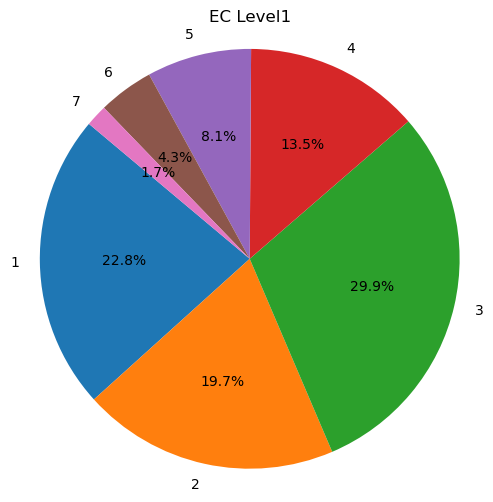

1    246
2    213
3    323
4    146
5     87
6     46
7     18
Name: ec_level1, dtype: int64

In [38]:
from matplotlib import pyplot as plt
ec_value_counts = all_reformated_mcsa_data_filtered_df['ec_level1'].value_counts().sort_index()
plt.figure(figsize=(6, 6))
plt.pie(ec_value_counts.values, labels=ec_value_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('EC Level1')
plt.axis('equal')
plt.show()
ec_value_counts

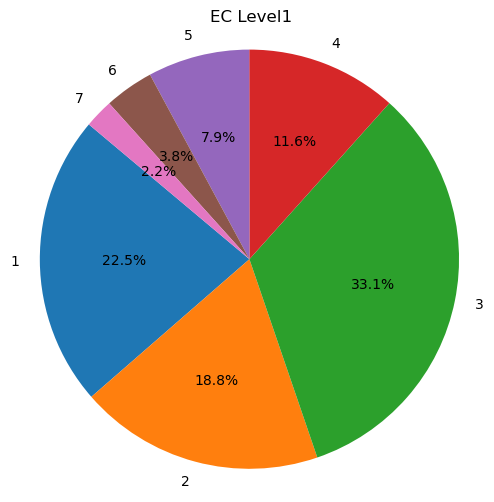

1    172
2    144
3    253
4     89
5     60
6     29
7     17
Name: ec_level1, dtype: int64

In [39]:
not_coincide_ec_value_counts = not_coincide_reformated_mcsa_data_filtered_df['ec_level1'].value_counts().sort_index()
plt.figure(figsize=(6, 6))
plt.pie(not_coincide_ec_value_counts.values, labels=not_coincide_ec_value_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('EC Level1')
plt.axis('equal')
plt.show()
not_coincide_ec_value_counts

In [40]:
mcsa_valid_df = pd.DataFrame()
mcsa_test_df = pd.DataFrame()
for ec_level1, count in ec_value_counts.items():
    this_ec_level1_data = not_coincide_reformated_mcsa_data_filtered_df.loc[not_coincide_reformated_mcsa_data_filtered_df['ec_level1']==ec_level1]
    
    test_valid_size = int(count * 0.2)
    
    
    this_ec_level1_test_valid = this_ec_level1_data.sample(n=test_valid_size, random_state=123)
    this_ec_level1_train = this_ec_level1_data.drop(this_ec_level1_test_valid.index)
    this_ec_level1_test_valid = this_ec_level1_test_valid.drop(this_ec_level1_test_valid.loc[this_ec_level1_test_valid['cluster'].isin(this_ec_level1_train['cluster']) | this_ec_level1_test_valid['cluster'].isin(mcsa_train_df['cluster'])].index)
        
    this_ec_level1_test = this_ec_level1_test_valid.sample(frac=0.5, random_state=123)
    this_ec_level1_valid = this_ec_level1_test_valid.drop(this_ec_level1_test.index)
    
    assert this_ec_level1_test['cluster'].isin(this_ec_level1_train['cluster']).sum() == 0
    assert this_ec_level1_valid['cluster'].isin(this_ec_level1_train['cluster']).sum() == 0
    
    assert this_ec_level1_test['cluster'].isin(mcsa_train_df['cluster']).sum() == 0
    assert this_ec_level1_valid['cluster'].isin(mcsa_train_df['cluster']).sum() == 0
    
    mcsa_valid_df = pd.concat([mcsa_valid_df, this_ec_level1_valid])
    mcsa_test_df = pd.concat([mcsa_test_df, this_ec_level1_test])

In [41]:
print(mcsa_valid_df.shape)
print(mcsa_test_df.shape)


(108, 9)
(105, 9)


In [42]:
remaining_mcsa_train_df = not_coincide_reformated_mcsa_data_filtered_df.drop(mcsa_valid_df.index)
remaining_mcsa_train_df = remaining_mcsa_train_df.drop(mcsa_test_df.index)
mcsa_train_df = pd.concat([mcsa_train_df, remaining_mcsa_train_df])

In [43]:
# 删去 De novo design of luciferases using deep learning 这篇文章中使用的酶样例
rfdiffuision_data = ['O87172', 'P00655', 'P11586', 'P21164', 'P0A6L0', 'Q96C23']
rfdiffuision_data_cluster = [alphafold_id2cluster[uniprot_id] for uniprot_id in rfdiffuision_data if uniprot_id in alphafold_id2cluster]
mcsa_train_df = mcsa_train_df.drop(mcsa_train_df.loc[mcsa_train_df['cluster'].isin(rfdiffuision_data_cluster)].index)

In [44]:
print(mcsa_train_df.shape)

(824, 9)


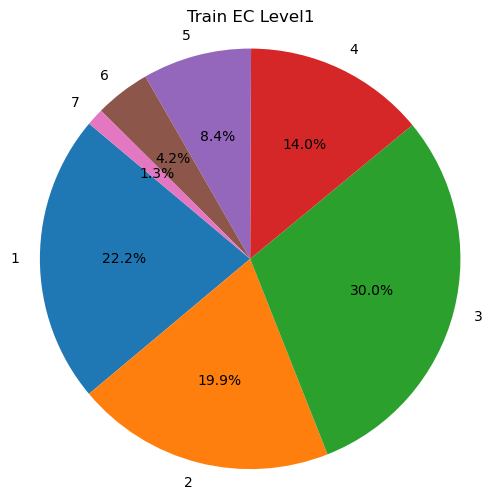

1    183
2    164
3    247
4    115
5     69
6     35
7     11
Name: ec_level1, dtype: int64

In [45]:
train_ec_value_counts = mcsa_train_df['ec_level1'].value_counts().sort_index()
plt.figure(figsize=(6, 6))
plt.pie(train_ec_value_counts.values, labels=train_ec_value_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Train EC Level1')
plt.axis('equal')
plt.show()
train_ec_value_counts

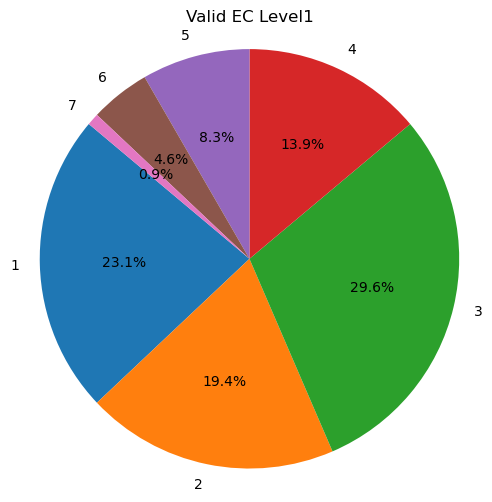

1    25
2    21
3    32
4    15
5     9
6     5
7     1
Name: ec_level1, dtype: int64

In [46]:
valid_ec_value_counts = mcsa_valid_df['ec_level1'].value_counts().sort_index()
plt.figure(figsize=(6, 6))
plt.pie(valid_ec_value_counts.values, labels=valid_ec_value_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Valid EC Level1')
plt.axis('equal')
plt.show()
valid_ec_value_counts

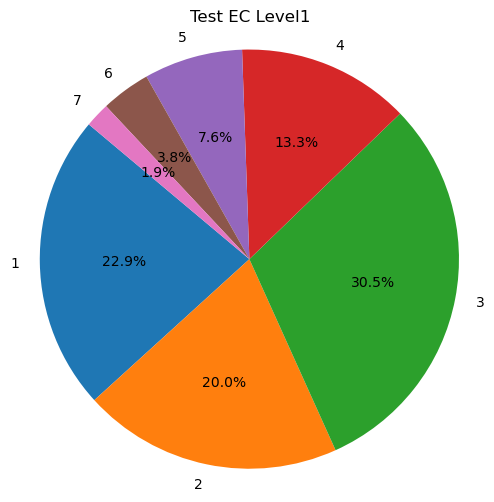

1    24
2    21
3    32
4    14
5     8
6     4
7     2
Name: ec_level1, dtype: int64

In [47]:
test_ec_value_counts = mcsa_test_df['ec_level1'].value_counts().sort_index()
plt.figure(figsize=(6, 6))
plt.pie(test_ec_value_counts.values, labels=test_ec_value_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Test EC Level1')
plt.axis('equal')
plt.show()
test_ec_value_counts

In [48]:
assert mcsa_test_df['cluster'].isin(ec_react_100_train['cluster']).sum() == 0

In [49]:
assert mcsa_test_df['cluster'].isin(mcsa_train_df['cluster']).sum() == 0

In [50]:
mcsa_test_df['cluster'].isin(mcsa_train_df['cluster']).sum()

0

In [51]:
assert mcsa_test_df['cluster'].isin(mcsa_train_df['cluster']).sum() == 0

In [52]:
for uniprot_id in rfdiffuision_data:
    print(alphafold_id2cluster[uniprot_id] not in mcsa_train_df['cluster'].tolist())


True
True
True
True
True
True


In [53]:
mcsa_save_path = '../dataset/raw_dataset/mcsa/split_dataset'
os.makedirs(mcsa_save_path, exist_ok=True)
mcsa_train_df.to_csv(os.path.join(mcsa_save_path, 'mcsa_train.csv'), index=False)
mcsa_valid_df.to_csv(os.path.join(mcsa_save_path, 'mcsa_valid.csv'), index=False)
mcsa_test_df.to_csv(os.path.join(mcsa_save_path, 'mcsa_test.csv'), index=False)